In [36]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import os

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.ornstein_uhlenbeck import OrnsteinUhlenbeck
from rivapy.models import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel
from rivapy.pricing.green_ppa_pricing import price
from rivapy.instruments.ppa_specification import GreenPPASpecification
import numpy as np
from scipy.special import comb

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models

In [2]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
    result *= x ** (N + 1)
    return result

def _logit(x):
    return np.log(x/(1-x))

def _inv_logit(x):
    return 1.0/(1+np.exp(-x))


class SmoothstepSupplyCurve: 
    def __init__(self, s,N):
        self.s = s
        self.N = N
        
    def compute(self, residual, highest_price):
        #wind_production = wind_production#np.maximum(np.minimum(wind_production, 0.99), 0.01)
        #residual = (1.0-wind_production)
        residual = np.power(residual, self.s)
        return smoothstep(residual, N=self.N)*highest_price


- $p(t,T)$: Forward-Price zum Zeitpunkt $t$ mit Expiry $T$
- $f_i(t,T)$: Forecast der i-ten Technology für $T$ zum Zeitpunkt $t$
    - Annahme: Forecast stueckweise Konstant in der Zeit (Sprung an Forecast Terminen)


Wuenschenswert:
- $f_i(t,T)=E\left[f_i(T,T)\mid f_i(t,T)\right]$
- $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$

Einfache Moeglichkeit (ohne die wuenschenswerten Punkte einzuhalten): 
- $c(t,T)$: Hoechster Preis, der aufgrund der Angebotskurve zustande kommen kann
- $r(x)$: Residual demand curve mit Werten zwischen 0 und 1
$$
p(t,T) = c(t,T)\cdot r(1.0 - \sum_i f_i(t,T))
$$
Unabghängigkeit von $c$ und $f_i$:
$$
E\left[p(T,T)\right] = E\left[c(T,T)\right]E\left[r(1.0 - \sum_i f_i(T,T))\right]
$$
und wenn 
$$E\left[c(T,T))\right]=c(t,T)$$ 
und 
$$E\left[r(1.0 - \sum_i f_i(T,T)\right]=r(1.0 - \sum_i f_i(t,T))$$
haben wir $p(t,T)=E\left[p(T,T)\mid p(t,T)\right]$. Wenn $r$ linear, d.h. $r(x)=x$ dann einfach!


$$
dF = \lambda(F-a-r(f))dt + \sigma dW
$$

In [3]:
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1] + 10*24*i/(365*24.0) for i in range(4)]
#forward_expiries = [timegrid[-1] + i for i in range(4)]
n_sims = 10_000
wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=1.0, volatility=0.30, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )

rnd = np.random.normal(size=wind_forecast_model.rnd_shape(n_sims, timegrid.shape[0]))
wind = wind_forecast_model.simulate(timegrid, rnd)

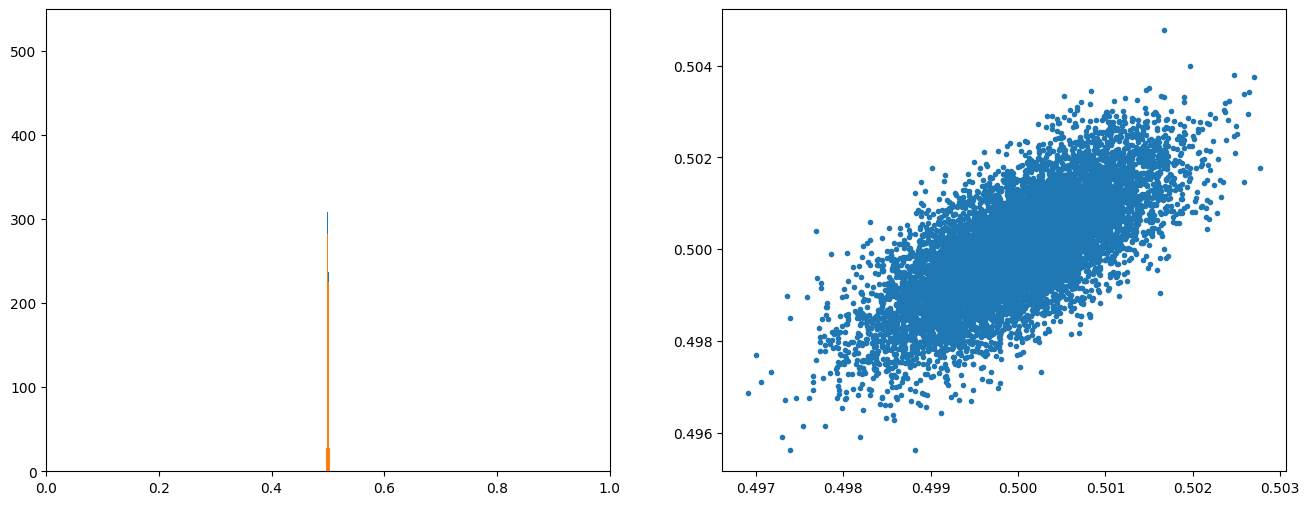

In [4]:
expiry1 = 1
expiry2 = 2#5*24
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(_inv_logit(wind._paths[expiry1,:]), density=True, bins=100)
plt.hist(_inv_logit(wind._paths[expiry2,:]), density=True, bins=100)
plt.xlim(0.0,1.0)
plt.subplot(1,2,2)
plt.plot(_inv_logit(wind._paths[expiry1,:]), _inv_logit(wind._paths[expiry2,:]), '.');

In [5]:
wind_forecast_model_2 = WindPowerForecastModel(speed_of_mean_reversion=2.0, volatility=0.6, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            )
region_wind_model = MultiRegionWindForecastModel([(0.5, wind_forecast_model, [0.6, 0.4]),
                              (0.5, wind_forecast_model_2, [0.4, 0.6])])

In [6]:
results = region_wind_model.simulate(timegrid, rnd)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
expiry = -1
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(_inv_logit(results[0]._paths[expiry,:]), _inv_logit(results[1]._paths[expiry,:]), '.');

plt.subplot(1,2,2)
plt.hist(_inv_logit(results[0]._paths[expiry,:]), density=True, label='region 0', bins=100)
plt.hist(_inv_logit(results[1]._paths[expiry,:]),  density=True, label='region 1', bins=100, alpha=0.8);


In [ ]:
for fwd in [0,-1]:#range(wind.n_forwards()):
    fwd_values = wind.get_fwd(0, fwd)
    plt.hist(fwd_values, bins=100, label='expiry ' + str(wind.expiry(fwd))[:6], alpha=0.3, density=True)
plt.legend();

In [ ]:
timestep = 20
fwd1 = 0
fwd2 = 1
fwd_values1 = wind.get_fwd(timestep, fwd1)
fwd_values2 = wind.get_fwd(timestep, fwd2)
plt.plot(fwd_values1, fwd_values2, '.', alpha=0.1)
plt.legend();

In [ ]:

class ResidualDemandForwardModel:
        
    def __init__(self, wind_power_forecast, highest_price_ou_model, supply_curve):
        self.wind_power_forecast = wind_power_forecast
        self.highest_price_ou_model = highest_price_ou_model
        self.supply_curve = supply_curve
        
    def simulate(self, timegrid, rnd, forecast_timepoints, highest_price):
        highest_prices = self.highest_price_ou_model.simulate(timegrid, 1.0, rnd[0,:])*highest_price
        wind = self.wind_power_forecast.simulate(timegrid, rnd[1,:])._paths
        result = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_forwards()))
        current_forecast_residual = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_forwards()))
        for i in range(timegrid.shape[0]):
            for j in range(self.wind_power_forecast.n_forwards()):
                if i in forecast_timepoints:
                        current_forecast_residual[i,:,j] = 1.0-self.wind_power_forecast.get_forward(wind[i,:], timegrid[i],j)
                else:
                    current_forecast_residual[i,:,j] = current_forecast_residual[i-1,:,j]
            for j in range(self.wind_power_forecast.n_forwards()):
                result[i,:,j] =  self.supply_curve.compute(current_forecast_residual[i,:,j], highest_prices[i,:] )
        return result, current_forecast_residual

In [ ]:
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, highest_price, supply_curve)

In [ ]:
n_sims = 1000
rnd = np.random.normal(size=(2,timegrid.shape[0], n_sims))
fwd_prices, fwd_residuals = rdm.simulate(timegrid, rnd, forecast_points, highest_price=1000)

In [ ]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])[:6]
    color = None
    for i in range(100):
        lines = plt.plot(timegrid, fwd_prices[:,i,T], '-', alpha=0.1, label=label, color = color)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$p(t,T)$')
plt.legend()
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)
plt.subplot(1,3,2)
x = np.linspace(0.0,1.0,50)
plt.plot(x,rdm.supply_curve.compute(x, 1000))
plt.xlabel('residual demand')
plt.ylabel('price')
plt.subplot(1,3,3)
for T in [-2,0]:
    label = 'T='+str(forward_expiries[T])
    color = None
    for i in range(100):
        plt.plot(timegrid, 1.0-fwd_residuals[:,i,T], '-', color = color, alpha=0.1)
        color = lines[0].get_color()
        label=None
plt.xlabel('t')
plt.ylabel('$f_i(t,T)$')
plt.legend();

In [ ]:
plt.figure(figsize = (16,4))

for T in [0,1,2]:
    plt.subplot(1,3,T+1)
    label = 'T='+str(forward_expiries[T])[:6]
    plt.plot( 1.0-fwd_residuals[-1,:,T], fwd_prices[-1,:,T], '.', alpha=0.1, label=label)
    label=None
plt.ylabel('$p(T,T)$')
plt.xlabel('$f_i(T,T)$')
plt.legend();

In [ ]:
fwd_prices[-1,:,T].shape

In [ ]:
for i in range(100):
    plt.plot(timegrid, result[:,i,-2], '-b', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)

In [ ]:
wind = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=[1.0+i/(365.0*24.0) for i in range(24)],
                            forecasts = [0.8-i*0.4/23.0 for i in range(24)])

timegrid = np.linspace(0.0, 1.0, 100)
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = wind.simulate(timegrid, rnd)

expiry = 0
timepoint = 99
t = timegrid[timepoint]
fwd = wind.get_forward(paths[timepoint], t, expiry)
print(np.mean(fwd))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(fwd, bins = 100);
plt.subplot(1,2,2)
plt.plot(paths[timepoint], fwd,'.');

In [ ]:

timepoint = -1
forecast = 0.001
ou = OrnsteinUhlenbeck(speed_of_mean_reversion=0.20, volatility=0.4, mean_reversion_level=0.0)
timegrid = np.linspace(0.0, 1.0, 100)
#scaling = 
correction = _logit(forecast)-ou.compute_expected_value(0.0, timegrid[timepoint])

print(_inv_logit(ou.compute_expected_value(0.0, timegrid[timepoint])+correction))
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = ou.simulate(timegrid, 0.0, rnd) + correction
paths_inv_logit = _inv_logit(paths)

#plt.hist(paths[-1,:], bins=100)
plt.hist(paths_inv_logit[timepoint,:], bins=100);
print('mean ou path ', np.mean(paths[timepoint,:]), 'inverse_logit of mean ',_inv_logit(np.mean(paths[timepoint,:])), 
      ' mean of inverse logit',np.mean(paths_inv_logit[timepoint,:]))

_logit(forecast)

# Hedging

In [70]:
from rivapy.models.residual_demand_model import SmoothstepSupplyCurve
days = 2
timegrid = np.linspace(0.0, days*1.0/365.0, days*24)
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1]]
n_sims = 1_000

wind_forecast_model = WindPowerForecastModel(speed_of_mean_reversion=0.5, volatility=1.80, 
                            expiries=forward_expiries,
                            forecasts = [0.8, 0.8,0.8,0.8],#*len(forward_expiries)
                            name = 'Wind_Onshore'
                            )
highest_price = OrnsteinUhlenbeck(1.0, 1.0, mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 0)
rdm = ResidualDemandForwardModel(wind_forecast_model, 
                                 highest_price,
                                 supply_curve,
                                 max_price = 1.0,
                                 forecast_hours=[#6, 
                                                 10, 14, 18], 
                                region_to_capacity=None)

In [71]:
val_date = dt.datetime(2023,1,1)
spec = GreenPPASpecification(technology = 'Wind_Onshore',
                             schedule = [val_date + dt.timedelta(days=2)], 
                             fixed_price=strike,
                             max_capacity = 1.0)

In [72]:

tensorboard_logdir = None#os.path.join("logs", dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
result = price(val_date, spec, rdm , 
               depth=3, nb_neurons=64, n_sims = n_sims, regularization= 10.0, 
              epochs = 200, 
              verbose=1, 
              initial_lr = 1e-2,
              batch_size=200,
              decay_rate=0.6,
              tensorboard_logdir=tensorboard_logdir
            )

C:\Users\doeltz\development\RiVaPy\notebooks\models\../..\rivapy\tools\datetime_grid.py:23: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  self.dates = pd.date_range(start, end, freq=freq, tz=tz, closed='left').to_pydatetime()


Epoch 1/200
5/5 [==============================] - 15s 35ms/step - loss: 0.0263
Epoch 2/200
5/5 [==============================] - 0s 39ms/step - loss: 0.0031
Epoch 3/200
5/5 [==============================] - 0s 34ms/step - loss: 0.0022
Epoch 4/200
5/5 [==============================] - 0s 36ms/step - loss: 0.0012
Epoch 5/200
5/5 [==============================] - 0s 34ms/step - loss: 6.8510e-04
Epoch 6/200
5/5 [==============================] - 0s 35ms/step - loss: 1.6105e-04
Epoch 7/200
5/5 [==============================] - 0s 43ms/step - loss: 1.7771e-04
Epoch 8/200
5/5 [==============================] - 0s 35ms/step - loss: 7.3658e-05
Epoch 9/200
5/5 [==============================] - 0s 35ms/step - loss: 4.4243e-05
Epoch 10/200
5/5 [==============================] - 0s 35ms/step - loss: 3.8569e-05
Epoch 11/200
5/5 [==============================] - 0s 36ms/step - loss: 8.1905e-06
Epoch 12/200
5/5 [==============================] - 0s 43ms/step - loss: 1.6139e-05
Epoch 13/200
5/5

5/5 [==============================] - 0s 38ms/step - loss: 1.1608e-06
Epoch 99/200
5/5 [==============================] - 0s 40ms/step - loss: 1.1563e-06
Epoch 100/200
5/5 [==============================] - 0s 36ms/step - loss: 1.1657e-06
Epoch 101/200
5/5 [==============================] - 0s 35ms/step - loss: 1.1765e-06
Epoch 102/200
5/5 [==============================] - 0s 36ms/step - loss: 1.1248e-06
Epoch 103/200
5/5 [==============================] - 0s 35ms/step - loss: 1.1559e-06
Epoch 104/200
5/5 [==============================] - 0s 38ms/step - loss: 1.1582e-06
Epoch 105/200
5/5 [==============================] - 0s 35ms/step - loss: 1.1541e-06
Epoch 106/200
5/5 [==============================] - 0s 35ms/step - loss: 1.1700e-06
Epoch 107/200
5/5 [==============================] - 0s 37ms/step - loss: 1.1481e-06
Epoch 108/200
5/5 [==============================] - 0s 37ms/step - loss: 1.1555e-06
Epoch 109/200
5/5 [==============================] - 0s 36ms/step - loss: 1.1433

5/5 [==============================] - 0s 40ms/step - loss: 1.1472e-06
Epoch 195/200
5/5 [==============================] - 0s 36ms/step - loss: 1.1358e-06
Epoch 196/200
5/5 [==============================] - 0s 37ms/step - loss: 1.1487e-06
Epoch 197/200
5/5 [==============================] - 0s 36ms/step - loss: 1.1280e-06
Epoch 198/200
5/5 [==============================] - 0s 39ms/step - loss: 1.1380e-06
Epoch 199/200
5/5 [==============================] - 0s 39ms/step - loss: 1.1240e-06
Epoch 200/200
5/5 [==============================] - 0s 37ms/step - loss: 1.1264e-06


strike 0.20071750565291616


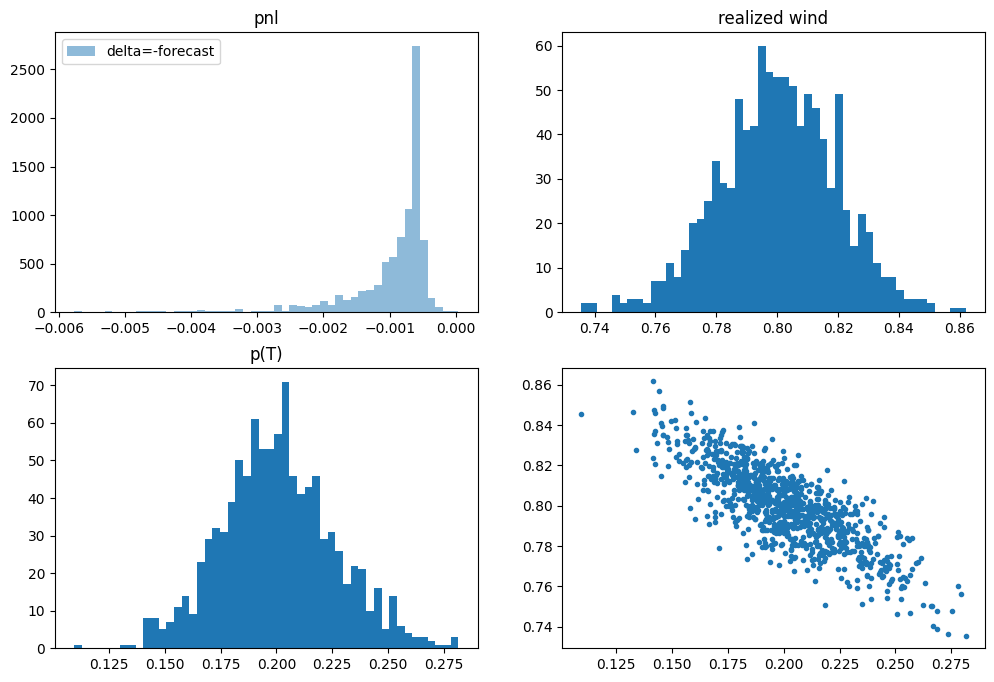

In [66]:
plt.figure(figsize=(12,8))
#forecast_points = [i for i in range(len(timegrid)) if i%8==0]
fwd_prices = result.fwd_prices
forecasts = result.forecasts
strike = fwd_prices[:,-1].mean()
print('strike', strike)
plt.subplot(2,2,1)
#print('hedge_delta', (-fwd_residuals[-1]+1.0))
pnl_no_hedge = (fwd_prices[:,-1]-strike)*forecasts[:,-1]
#bins = plt.hist(pnl_no_hedge, bins=50, label='no hedge', density=True)
delta = -forecasts[:,0]
pnl_hedge = pnl_no_hedge + (fwd_prices[:,-1]-fwd_prices[:,0])*delta
plt.hist(pnl_hedge,  label='delta=-forecast', alpha=0.5, density=True, bins=50)
#delta = -0.8*(-fwd_residuals[0,:]+1.0)
#pnl_hedge = pnl_no_hedge + (fwd_prices[-1,:]-fwd_prices[0,:])*delta
#plt.hist(pnl_hedge,  label='delta=-0.8*forecast', alpha=0.5, density=True, bins=50)
plt.legend()
plt.title('pnl')
plt.subplot(2,2,2)
plt.hist(forecasts[:,-1], bins=50);
plt.title('realized wind')
plt.subplot(2,2,3)
plt.hist(fwd_prices[:,-1], bins=50)
plt.title('p(T)')
plt.subplot(2,2,4)
plt.plot(fwd_prices[:,-1], forecasts[:,-1],'.');

In [73]:
pnl = result.hedge_model([fwd_prices.astype(np.float32), forecasts.astype(np.float32)])

32/32 [==============================] - 0s 2ms/step


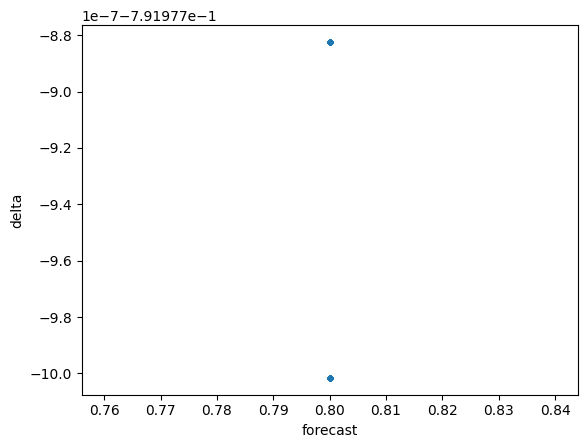

In [78]:
t = 0
delta = result.hedge_model.model.predict([fwd_prices[:,t], forecasts[:,t], np.array([timegrid[t]]*forecasts.shape[0])]).reshape((-1))
plt.plot( -fwd_residuals[t,:]+1.0, delta,'.')
plt.ylabel('delta')
plt.xlabel('forecast');

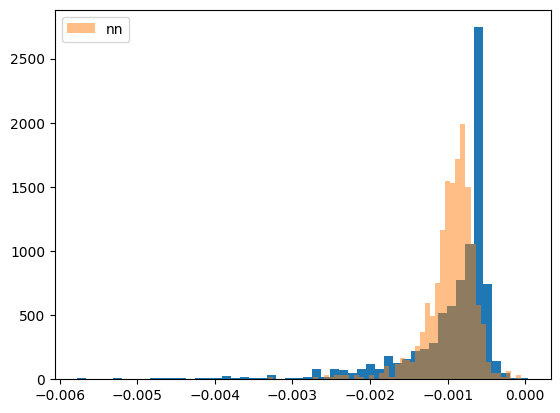

In [77]:
plt.hist(pnl_hedge, bins=50, density=True)
plt.hist(pnl, bins=50, density=True, alpha=0.5, label='nn')
plt.legend();